In [72]:
# Importing modules
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.models import vgg11, VGG11_Weights

# Finding device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device: {}".format(device))

Device: cuda:0


In [53]:
# Processing validation label
import pandas as pd

# Extracting image to class name mapping
val_targets = pd.read_csv("../../imagenet_data/LOC_val_solution.csv")

def get_class(s):
    return s.split(' ', 1)[0]
    
val_targets['PredictionString'] = val_targets['PredictionString'].apply(get_class)
val_targets = val_targets.set_index('ImageId')['PredictionString'].to_dict()

# Extracting class name to class number mapping
target_to_class = {i: None for i in range(0,1000)}
with open('../../imagenet_data/LOC_synset_mapping.txt', 'r') as f:
    line = f.readline()
    count = 0
    while line:
        target_to_class[count] = line.split(' ', 1)[0]
        line = f.readline()
        count += 1
target_to_class = {j: i for i, j in target_to_class.items()}

# Joining both to generate image to class number mapping
for key, value in val_targets.items():
    val_targets[key] = target_to_class[value]

# Sanity check
print('Number of Validation Images with Targets: {}\n'.format(len(val_targets)))
print('Number of Classes: {}\n'.format(len(target_to_class)))
print('Three First Entries of Target Dictionary:')
for i, (key, value) in enumerate(val_targets.items()):
    if i >= 3:
        break
    print(key, value)

Number of Validation Images with Targets: 50000

Number of Classes: 1000

Three First Entries of Target Dictionary:
ILSVRC2012_val_00048981 740
ILSVRC2012_val_00037956 587
ILSVRC2012_val_00026161 241


Batch Size: torch.Size([4, 3, 224, 224])


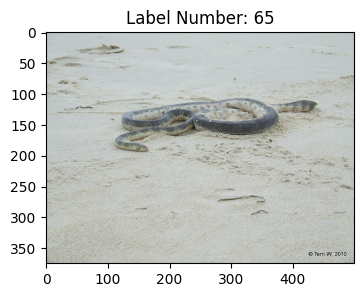

In [84]:
# Creating validation dataset
import os
from torchvision.io import read_image
import matplotlib.pyplot as plt
%matplotlib inline

class imagenet_dataset(Dataset):
    def __init__(self, data_path, data_targets, transform=None):
        self.data_path = data_path
        self.data_list = sorted(os.listdir(data_path))
        self.data_targets = data_targets
        self.transform = transform
    
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        image = read_image(os.path.join(self.data_path, self.data_list[idx]))
        
        if self.transform:
            image = self.transform(image)

        label = self.data_targets[self.data_list[idx].split('.', 1)[0]]
        
        return image, label

# Sanity check
val_imagenet = imagenet_dataset('../../imagenet_data/Data/CLS-LOC/val/', val_targets)
for img, label in val_imagenet:
    plt.figure(figsize=(4, 3))
    plt.title('Label Number: {}'.format(label))
    plt.imshow(img.permute(1, 2, 0))
    break

# Testing dataloader
val_imagenet = imagenet_dataset('../../imagenet_data/Data/CLS-LOC/val/', val_targets, VGG11_Weights.IMAGENET1K_V1.transforms())
dataloader = DataLoader(val_imagenet, batch_size=4, shuffle=True)

for batch in dataloader:
    print('Batch Size: {}'.format(batch[0].size()))
    break

In [49]:
# Initializing models
models = []
models.append(vgg11(weights='IMAGENET1K_V1'))

for model in models:
    if device != 'cpu':
        model.cuda()
    model.eval()

In [13]:
# Initializing transforms
transforms = []
transforms.append(VGG11_Weights.IMAGENET1K_V1.transforms())